In [245]:
import warnings
warnings.filterwarnings(action='ignore')
from pandas_profiling import ProfileReport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import xgboost
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from ipywidgets import interact, fixed
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline
import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [167]:
atbat = pd.read_csv('atbats.csv')
atbat2 = pd.read_csv('2019_atbats.csv')
atbat.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,2015000002,518792,Double,201500001,1,1,0,L,452657,L,True
2,2015000003,407812,Single,201500001,1,1,0,L,452657,R,True
3,2015000004,425509,Strikeout,201500001,1,2,0,L,452657,R,True
4,2015000005,571431,Strikeout,201500001,1,3,0,L,452657,L,True


In [168]:
pitches = pd.read_csv('pitches.csv')
pitches2 = pd.read_csv('2019_pitches.csv')
pitches.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,...,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,...,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,...,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,...,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,...,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0


In [169]:
name = pd.read_csv('player_names.csv')
name.head()

,id,first_name,last_name
0,452657,Jon,Lester
1,425794,Adam,Wainwright
2,457435,Phil,Coke
3,435400,Jason,Motte
4,519166,Neil,Ramirez


In [170]:
atbat.shape, pitches.shape

((740389, 11), (2867154, 40))

In [171]:
df = atbat.merge(pitches, on  = 'ab_id')
df2 = atbat2.merge(pitches2, on = 'ab_id')
df.head().T

,0,1,2,3,4
ab_id,2015000001,2015000001,2015000001,2015000001,2015000001
batter_id,572761,572761,572761,572761,572761
event,Groundout,Groundout,Groundout,Groundout,Groundout
g_id,201500001,201500001,201500001,201500001,201500001
inning,1,1,1,1,1
o,1,1,1,1,1
p_score,0,0,0,0,0
p_throws,L,L,L,L,L
pitcher_id,452657,452657,452657,452657,452657
stand,L,L,L,L,L


In [172]:
droplist = df.columns.tolist()
droplist = droplist[11:38]
df.drop(droplist, axis = 1, inplace = True)
df.shape

(2867154, 23)

In [173]:
df2.drop(droplist, axis = 1, inplace = True)
df2.shape

(728790, 23)

In [174]:
df.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,...,pitch_type,event_num,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,4,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,5,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,6,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,CU,7,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0


In [175]:
df.drop(['event', 'code', 'event_num'], axis = 1, inplace= True)
df2.drop(['event', 'code', 'event_num'], axis = 1, inplace= True)
df.shape

(2867154, 20)

In [176]:
df.head()

,ab_id,batter_id,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,type,pitch_type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,2015000001,572761,201500001,1,1,0,L,452657,L,True,S,FF,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2015000001,572761,201500001,1,1,0,L,452657,L,True,S,FF,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,2015000001,572761,201500001,1,1,0,L,452657,L,True,S,FF,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,2015000001,572761,201500001,1,1,0,L,452657,L,True,B,FF,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,2015000001,572761,201500001,1,1,0,L,452657,L,True,B,CU,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0


In [177]:
df = df[(df['type'] == 'S') | (df['type'] == 'B')]
df2 = df2[(df2['type'] == 'S') | (df2['type'] == 'B')]
df.shape

(2353991, 20)

In [178]:
df.isna().sum()

ab_id             0
batter_id         0
g_id              0
inning            0
o                 0
p_score           0
p_throws          0
pitcher_id        0
stand             0
top               0
type              0
pitch_type    12885
b_score           0
b_count           0
s_count           0
outs              0
pitch_num         0
on_1b             0
on_2b             0
on_3b             0
dtype: int64

In [179]:
df.pitch_type.value_counts()

FF    841648
SL    376082
FT    265986
CH    234448
CU    199658
SI    192757
FC    120977
KC     56646
FS     35525
KN      9060
IN      6197
FO       674
EP       663
PO       627
SC        89
UN        53
AB         9
FA         7
Name: pitch_type, dtype: int64

In [180]:
df = df.dropna()
df2 = df2.dropna()
df.shape

(2341106, 20)

In [181]:
df.dtypes

ab_id           int64
batter_id       int64
g_id            int64
inning          int64
o               int64
p_score         int64
p_throws       object
pitcher_id      int64
stand          object
top              bool
type           object
pitch_type     object
b_score       float64
b_count       float64
s_count       float64
outs          float64
pitch_num     float64
on_1b         float64
on_2b         float64
on_3b         float64
dtype: object

In [182]:
changelist = df.columns.tolist()[12:17]
changelist2 = df.columns.tolist()[17:20]
changelist, changelist2

(['b_score', 'b_count', 's_count', 'outs', 'pitch_num'],
 ['on_1b', 'on_2b', 'on_3b'])

In [183]:
df[changelist] = df[changelist].astype(int)
df[changelist2] = df[changelist2].astype(bool)

df.dtypes

ab_id          int64
batter_id      int64
g_id           int64
inning         int64
o              int64
p_score        int64
p_throws      object
pitcher_id     int64
stand         object
top             bool
type          object
pitch_type    object
b_score        int32
b_count        int32
s_count        int32
outs           int32
pitch_num      int32
on_1b           bool
on_2b           bool
on_3b           bool
dtype: object

In [184]:
df2.dtypes

inning        float64
top           float64
ab_id         float64
g_id          float64
p_score       float64
batter_id       int64
pitcher_id      int64
stand          object
p_throws       object
o               int64
type           object
pitch_type     object
b_score       float64
b_count       float64
s_count       float64
outs          float64
pitch_num     float64
on_1b         float64
on_2b         float64
on_3b         float64
dtype: object

In [185]:
changelist = df2.columns.tolist()[0:5]

df2[changelist] = df2[changelist].astype(int)
df2.dtypes

inning          int32
top             int32
ab_id           int32
g_id            int32
p_score         int32
batter_id       int64
pitcher_id      int64
stand          object
p_throws       object
o               int64
type           object
pitch_type     object
b_score       float64
b_count       float64
s_count       float64
outs          float64
pitch_num     float64
on_1b         float64
on_2b         float64
on_3b         float64
dtype: object

In [186]:
df.type.value_counts(normalize = True)

S    0.557675
B    0.442325
Name: type, dtype: float64

In [187]:
df.head()

,ab_id,batter_id,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,type,pitch_type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,2015000001,572761,201500001,1,1,0,L,452657,L,True,S,FF,0,0,0,0,1,False,False,False
1,2015000001,572761,201500001,1,1,0,L,452657,L,True,S,FF,0,0,1,0,2,False,False,False
2,2015000001,572761,201500001,1,1,0,L,452657,L,True,S,FF,0,0,2,0,3,False,False,False
3,2015000001,572761,201500001,1,1,0,L,452657,L,True,B,FF,0,0,2,0,4,False,False,False
4,2015000001,572761,201500001,1,1,0,L,452657,L,True,B,CU,0,1,2,0,5,False,False,False


In [188]:
name.head()

,id,first_name,last_name
0,452657,Jon,Lester
1,425794,Adam,Wainwright
2,457435,Phil,Coke
3,435400,Jason,Motte
4,519166,Neil,Ramirez


In [189]:
df = df[(df['b_count'] == 3) & (df['s_count'] == 2)]
df2 = df2[(df2['b_count'] == 3) & (df2['s_count'] == 2)]

In [190]:
def name_load(x):
  try:
    condition = (name.id == x)
    return (name[condition].first_name.values + ' ' + name[condition].last_name.values)[0]
  except:
    return None

def name_load2(x):
  try:
    condition = (name.id == x)
    return (name[condition].first_name.values + ' ' + name[condition].last_name.values)[0]
  except:
    return None

In [191]:
df['batter_name'] = df['batter_id'].apply(name_load)
df.head(20)

,ab_id,batter_id,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,...,pitch_type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_name
43,2015000011,543939,201500001,2,1,0,L,452657,L,True,...,FF,1,3,2,1,6,False,False,False,Kolten Wong
44,2015000011,543939,201500001,2,1,0,L,452657,L,True,...,FF,1,3,2,1,7,False,False,False,Kolten Wong
64,2015000017,592609,201500001,2,1,2,R,425794,R,False,...,FF,0,3,2,0,6,False,True,False,Mike Olt
65,2015000017,592609,201500001,2,1,2,R,425794,R,False,...,CU,0,3,2,0,7,False,True,False,Mike Olt
91,2015000024,600303,201500001,3,0,2,R,425794,L,False,...,FF,0,3,2,0,6,False,False,False,Tommy La Stella
105,2015000026,624585,201500001,3,2,2,R,425794,R,False,...,FC,0,3,2,1,7,False,True,False,Jorge Soler
111,2015000027,519203,201500001,3,3,2,R,425794,L,False,...,CU,0,3,2,2,6,False,True,False,Anthony Rizzo
202,2015000049,624585,201500001,6,1,3,R,425794,R,False,...,FF,0,3,2,0,6,False,False,False,Jorge Soler
231,2015000058,570489,201500001,7,1,3,R,593372,L,False,...,FF,0,3,2,1,6,False,False,False,Arismendy Alcantara
232,2015000058,570489,201500001,7,1,3,R,593372,L,False,...,FT,0,3,2,1,7,False,False,False,Arismendy Alcantara


In [192]:
df.reset_index(inplace = True, drop = True)

In [193]:
df.head()

,ab_id,batter_id,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,...,pitch_type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_name
0,2015000011,543939,201500001,2,1,0,L,452657,L,True,...,FF,1,3,2,1,6,False,False,False,Kolten Wong
1,2015000011,543939,201500001,2,1,0,L,452657,L,True,...,FF,1,3,2,1,7,False,False,False,Kolten Wong
2,2015000017,592609,201500001,2,1,2,R,425794,R,False,...,FF,0,3,2,0,6,False,True,False,Mike Olt
3,2015000017,592609,201500001,2,1,2,R,425794,R,False,...,CU,0,3,2,0,7,False,True,False,Mike Olt
4,2015000024,600303,201500001,3,0,2,R,425794,L,False,...,FF,0,3,2,0,6,False,False,False,Tommy La Stella


In [194]:
df2.reset_index(inplace = True, drop = True)

In [195]:
df2.head()

,inning,top,ab_id,g_id,p_score,batter_id,pitcher_id,stand,p_throws,o,type,pitch_type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,4,0,2019000169,201900003,1,592663,527054,R,R,2,B,FF,1.0,3.0,2.0,2.0,6.0,0.0,0.0,0.0
1,3,0,2019000821,201900012,1,607208,594798,R,R,1,S,FF,0.0,3.0,2.0,0.0,7.0,0.0,0.0,0.0
2,4,0,2019000827,201900012,1,665742,594798,L,R,1,S,CH,0.0,3.0,2.0,0.0,6.0,0.0,0.0,0.0
3,6,1,2019001043,201900015,5,657557,468504,R,R,1,S,FT,3.0,3.0,2.0,0.0,6.0,0.0,0.0,0.0
4,9,1,2019001611,201900022,4,621453,489446,L,R,1,B,FF,1.0,3.0,2.0,1.0,7.0,0.0,0.0,0.0


In [196]:
df2['batter_name'] = df2['batter_id'].apply(name_load)
df2.head(20)

,inning,top,ab_id,g_id,p_score,batter_id,pitcher_id,stand,p_throws,o,...,pitch_type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_name
0,4,0,2019000169,201900003,1,592663,527054,R,R,2,...,FF,1.0,3.0,2.0,2.0,6.0,0.0,0.0,0.0,J.T. Realmuto
1,3,0,2019000821,201900012,1,607208,594798,R,R,1,...,FF,0.0,3.0,2.0,0.0,7.0,0.0,0.0,0.0,Trea Turner
2,4,0,2019000827,201900012,1,665742,594798,L,R,1,...,CH,0.0,3.0,2.0,0.0,6.0,0.0,0.0,0.0,Juan Soto
3,6,1,2019001043,201900015,5,657557,468504,R,R,1,...,FT,3.0,3.0,2.0,0.0,6.0,0.0,0.0,0.0,Paul DeJong
4,9,1,2019001611,201900022,4,621453,489446,L,R,1,...,FF,1.0,3.0,2.0,1.0,7.0,0.0,0.0,0.0,Steven Duggar
5,3,0,2019001953,201900027,0,572228,642231,R,R,3,...,SL,0.0,3.0,2.0,2.0,7.0,0.0,0.0,0.0,Luke Voit
6,3,1,2019002266,201900031,0,547982,543606,L,R,2,...,FF,0.0,3.0,2.0,2.0,6.0,0.0,0.0,0.0,Leonys Martin
7,5,1,2019003361,201900045,3,434670,527048,R,L,1,...,FF,0.0,3.0,2.0,0.0,6.0,0.0,0.0,0.0,Hanley Ramirez
8,10,1,2019003539,201900047,3,592348,607352,L,R,1,...,FT,3.0,3.0,2.0,1.0,6.0,0.0,0.0,0.0,Niko Goodrum
9,6,0,2019003601,201900048,1,664040,489119,L,L,3,...,FC,3.0,3.0,2.0,2.0,6.0,0.0,0.0,0.0,Brandon Lowe


In [197]:
df['pitcher_name'] = df['pitcher_id'].apply(name_load2)
df.head(20)

,ab_id,batter_id,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,...,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_name,pitcher_name
0,2015000011,543939,201500001,2,1,0,L,452657,L,True,...,1,3,2,1,6,False,False,False,Kolten Wong,Jon Lester
1,2015000011,543939,201500001,2,1,0,L,452657,L,True,...,1,3,2,1,7,False,False,False,Kolten Wong,Jon Lester
2,2015000017,592609,201500001,2,1,2,R,425794,R,False,...,0,3,2,0,6,False,True,False,Mike Olt,Adam Wainwright
3,2015000017,592609,201500001,2,1,2,R,425794,R,False,...,0,3,2,0,7,False,True,False,Mike Olt,Adam Wainwright
4,2015000024,600303,201500001,3,0,2,R,425794,L,False,...,0,3,2,0,6,False,False,False,Tommy La Stella,Adam Wainwright
5,2015000026,624585,201500001,3,2,2,R,425794,R,False,...,0,3,2,1,7,False,True,False,Jorge Soler,Adam Wainwright
6,2015000027,519203,201500001,3,3,2,R,425794,L,False,...,0,3,2,2,6,False,True,False,Anthony Rizzo,Adam Wainwright
7,2015000049,624585,201500001,6,1,3,R,425794,R,False,...,0,3,2,0,6,False,False,False,Jorge Soler,Adam Wainwright
8,2015000058,570489,201500001,7,1,3,R,593372,L,False,...,0,3,2,1,6,False,False,False,Arismendy Alcantara,Carlos Martinez
9,2015000058,570489,201500001,7,1,3,R,593372,L,False,...,0,3,2,1,7,False,False,False,Arismendy Alcantara,Carlos Martinez


In [198]:
df2['pitcher_name'] = df2['pitcher_id'].apply(name_load2)
df2.head(20)

,inning,top,ab_id,g_id,p_score,batter_id,pitcher_id,stand,p_throws,o,...,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_name,pitcher_name
0,4,0,2019000169,201900003,1,592663,527054,R,R,2,...,1.0,3.0,2.0,2.0,6.0,0.0,0.0,0.0,J.T. Realmuto,Julio Teheran
1,3,0,2019000821,201900012,1,607208,594798,R,R,1,...,0.0,3.0,2.0,0.0,7.0,0.0,0.0,0.0,Trea Turner,Jacob deGrom
2,4,0,2019000827,201900012,1,665742,594798,L,R,1,...,0.0,3.0,2.0,0.0,6.0,0.0,0.0,0.0,Juan Soto,Jacob deGrom
3,6,1,2019001043,201900015,5,657557,468504,R,R,1,...,3.0,3.0,2.0,0.0,6.0,0.0,0.0,0.0,Paul DeJong,Jhoulys Chacin
4,9,1,2019001611,201900022,4,621453,489446,L,R,1,...,1.0,3.0,2.0,1.0,7.0,0.0,0.0,0.0,Steven Duggar,Kirby Yates
5,3,0,2019001953,201900027,0,572228,642231,R,R,3,...,0.0,3.0,2.0,2.0,7.0,0.0,0.0,0.0,Luke Voit,Jimmy Yacabonis
6,3,1,2019002266,201900031,0,547982,543606,L,R,2,...,0.0,3.0,2.0,2.0,6.0,0.0,0.0,0.0,Leonys Martin,Jake Odorizzi
7,5,1,2019003361,201900045,3,434670,527048,R,L,1,...,0.0,3.0,2.0,0.0,6.0,0.0,0.0,0.0,Hanley Ramirez,Martin Perez
8,10,1,2019003539,201900047,3,592348,607352,L,R,1,...,3.0,3.0,2.0,1.0,6.0,0.0,0.0,0.0,Niko Goodrum,Joe Biagini
9,6,0,2019003601,201900048,1,664040,489119,L,L,3,...,3.0,3.0,2.0,2.0,6.0,0.0,0.0,0.0,Brandon Lowe,Wade Miley


In [199]:
col = df.columns.to_list()
df2 = df2[col]
df2.head()

,ab_id,batter_id,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,...,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_name,pitcher_name
0,2019000169,592663,201900003,4,2,1,R,527054,R,0,...,1.0,3.0,2.0,2.0,6.0,0.0,0.0,0.0,J.T. Realmuto,Julio Teheran
1,2019000821,607208,201900012,3,1,1,R,594798,R,0,...,0.0,3.0,2.0,0.0,7.0,0.0,0.0,0.0,Trea Turner,Jacob deGrom
2,2019000827,665742,201900012,4,1,1,R,594798,L,0,...,0.0,3.0,2.0,0.0,6.0,0.0,0.0,0.0,Juan Soto,Jacob deGrom
3,2019001043,657557,201900015,6,1,5,R,468504,R,1,...,3.0,3.0,2.0,0.0,6.0,0.0,0.0,0.0,Paul DeJong,Jhoulys Chacin
4,2019001611,621453,201900022,9,1,4,R,489446,L,1,...,1.0,3.0,2.0,1.0,7.0,0.0,0.0,0.0,Steven Duggar,Kirby Yates


In [200]:
df.isna().sum().sum(), df2.isna().sum().sum()

(0, 98)

In [201]:
df2 = df2.dropna()

In [202]:
df.dtypes

ab_id            int64
batter_id        int64
g_id             int64
inning           int64
o                int64
p_score          int64
p_throws        object
pitcher_id       int64
stand           object
top               bool
type            object
pitch_type      object
b_score          int32
b_count          int32
s_count          int32
outs             int32
pitch_num        int32
on_1b             bool
on_2b             bool
on_3b             bool
batter_name     object
pitcher_name    object
dtype: object

In [203]:
col = df.columns.to_list()[17:20]
df[col] = df[col].astype(int)
df['top']= df['top'].astype(int)
df.dtypes


ab_id            int64
batter_id        int64
g_id             int64
inning           int64
o                int64
p_score          int64
p_throws        object
pitcher_id       int64
stand           object
top              int32
type            object
pitch_type      object
b_score          int32
b_count          int32
s_count          int32
outs             int32
pitch_num        int32
on_1b            int32
on_2b            int32
on_3b            int32
batter_name     object
pitcher_name    object
dtype: object

In [204]:
col = df2.columns.to_list()[12:20]
df2[col] = df2[col].astype(int)

df2.dtypes

ab_id            int32
batter_id        int64
g_id             int32
inning           int32
o                int64
p_score          int32
p_throws        object
pitcher_id       int64
stand           object
top              int32
type            object
pitch_type      object
b_score          int32
b_count          int32
s_count          int32
outs             int32
pitch_num        int32
on_1b            int32
on_2b            int32
on_3b            int32
batter_name     object
pitcher_name    object
dtype: object

In [205]:
df2.head()

,ab_id,batter_id,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top,...,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_name,pitcher_name
0,2019000169,592663,201900003,4,2,1,R,527054,R,0,...,1,3,2,2,6,0,0,0,J.T. Realmuto,Julio Teheran
1,2019000821,607208,201900012,3,1,1,R,594798,R,0,...,0,3,2,0,7,0,0,0,Trea Turner,Jacob deGrom
2,2019000827,665742,201900012,4,1,1,R,594798,L,0,...,0,3,2,0,6,0,0,0,Juan Soto,Jacob deGrom
3,2019001043,657557,201900015,6,1,5,R,468504,R,1,...,3,3,2,0,6,0,0,0,Paul DeJong,Jhoulys Chacin
4,2019001611,621453,201900022,9,1,4,R,489446,L,1,...,1,3,2,1,7,0,0,0,Steven Duggar,Kirby Yates


In [206]:
df = df.drop(['batter_id', 'pitcher_id', 'o'], axis = 1)
df2 = df2.drop(['batter_id', 'pitcher_id', 'o'], axis = 1)

df.head()

,ab_id,g_id,inning,p_score,p_throws,stand,top,type,pitch_type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_name,pitcher_name
0,2015000011,201500001,2,0,L,L,1,S,FF,1,3,2,1,6,0,0,0,Kolten Wong,Jon Lester
1,2015000011,201500001,2,0,L,L,1,B,FF,1,3,2,1,7,0,0,0,Kolten Wong,Jon Lester
2,2015000017,201500001,2,2,R,R,0,S,FF,0,3,2,0,6,0,1,0,Mike Olt,Adam Wainwright
3,2015000017,201500001,2,2,R,R,0,S,CU,0,3,2,0,7,0,1,0,Mike Olt,Adam Wainwright
4,2015000024,201500001,3,2,R,L,0,S,FF,0,3,2,0,6,0,0,0,Tommy La Stella,Adam Wainwright


In [207]:
df['score_diff'] = df['p_score'] - df['b_score']
df2['score_diff'] = df2['p_score'] - df2['b_score']

df.head()

,ab_id,g_id,inning,p_score,p_throws,stand,top,type,pitch_type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_name,pitcher_name,score_diff
0,2015000011,201500001,2,0,L,L,1,S,FF,1,3,2,1,6,0,0,0,Kolten Wong,Jon Lester,-1
1,2015000011,201500001,2,0,L,L,1,B,FF,1,3,2,1,7,0,0,0,Kolten Wong,Jon Lester,-1
2,2015000017,201500001,2,2,R,R,0,S,FF,0,3,2,0,6,0,1,0,Mike Olt,Adam Wainwright,2
3,2015000017,201500001,2,2,R,R,0,S,CU,0,3,2,0,7,0,1,0,Mike Olt,Adam Wainwright,2
4,2015000024,201500001,3,2,R,L,0,S,FF,0,3,2,0,6,0,0,0,Tommy La Stella,Adam Wainwright,2


In [208]:
df['target'] = df['type'].apply(lambda x: 1 if (x == 'S') else 0)
df.head()

,ab_id,g_id,inning,p_score,p_throws,stand,top,type,pitch_type,b_score,...,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_name,pitcher_name,score_diff,target
0,2015000011,201500001,2,0,L,L,1,S,FF,1,...,2,1,6,0,0,0,Kolten Wong,Jon Lester,-1,1
1,2015000011,201500001,2,0,L,L,1,B,FF,1,...,2,1,7,0,0,0,Kolten Wong,Jon Lester,-1,0
2,2015000017,201500001,2,2,R,R,0,S,FF,0,...,2,0,6,0,1,0,Mike Olt,Adam Wainwright,2,1
3,2015000017,201500001,2,2,R,R,0,S,CU,0,...,2,0,7,0,1,0,Mike Olt,Adam Wainwright,2,1
4,2015000024,201500001,3,2,R,L,0,S,FF,0,...,2,0,6,0,0,0,Tommy La Stella,Adam Wainwright,2,1


In [209]:
df2['target'] = df2['type'].apply(lambda x: 1 if (x == 'S') else 0)
df2.head()

,ab_id,g_id,inning,p_score,p_throws,stand,top,type,pitch_type,b_score,...,s_count,outs,pitch_num,on_1b,on_2b,on_3b,batter_name,pitcher_name,score_diff,target
0,2019000169,201900003,4,1,R,R,0,B,FF,1,...,2,2,6,0,0,0,J.T. Realmuto,Julio Teheran,0,0
1,2019000821,201900012,3,1,R,R,0,S,FF,0,...,2,0,7,0,0,0,Trea Turner,Jacob deGrom,1,1
2,2019000827,201900012,4,1,R,L,0,S,CH,0,...,2,0,6,0,0,0,Juan Soto,Jacob deGrom,1,1
3,2019001043,201900015,6,5,R,R,1,S,FT,3,...,2,0,6,0,0,0,Paul DeJong,Jhoulys Chacin,2,1
4,2019001611,201900022,9,4,R,L,1,B,FF,1,...,2,1,7,0,0,0,Steven Duggar,Kirby Yates,3,0


In [210]:
df.drop(['type', 'b_count', 's_count'], axis = 1, inplace = True)
df2.drop(['type', 'b_count', 's_count'], axis = 1, inplace = True)

df.head()

,ab_id,g_id,inning,p_score,p_throws,stand,top,pitch_type,b_score,outs,pitch_num,on_1b,on_2b,on_3b,batter_name,pitcher_name,score_diff,target
0,2015000011,201500001,2,0,L,L,1,FF,1,1,6,0,0,0,Kolten Wong,Jon Lester,-1,1
1,2015000011,201500001,2,0,L,L,1,FF,1,1,7,0,0,0,Kolten Wong,Jon Lester,-1,0
2,2015000017,201500001,2,2,R,R,0,FF,0,0,6,0,1,0,Mike Olt,Adam Wainwright,2,1
3,2015000017,201500001,2,2,R,R,0,CU,0,0,7,0,1,0,Mike Olt,Adam Wainwright,2,1
4,2015000024,201500001,3,2,R,L,0,FF,0,0,6,0,0,0,Tommy La Stella,Adam Wainwright,2,1


In [211]:
df2.head()

,ab_id,g_id,inning,p_score,p_throws,stand,top,pitch_type,b_score,outs,pitch_num,on_1b,on_2b,on_3b,batter_name,pitcher_name,score_diff,target
0,2019000169,201900003,4,1,R,R,0,FF,1,2,6,0,0,0,J.T. Realmuto,Julio Teheran,0,0
1,2019000821,201900012,3,1,R,R,0,FF,0,0,7,0,0,0,Trea Turner,Jacob deGrom,1,1
2,2019000827,201900012,4,1,R,L,0,CH,0,0,6,0,0,0,Juan Soto,Jacob deGrom,1,1
3,2019001043,201900015,6,5,R,R,1,FT,3,0,6,0,0,0,Paul DeJong,Jhoulys Chacin,2,1
4,2019001611,201900022,9,4,R,L,1,FF,1,1,7,0,0,0,Steven Duggar,Kirby Yates,3,0


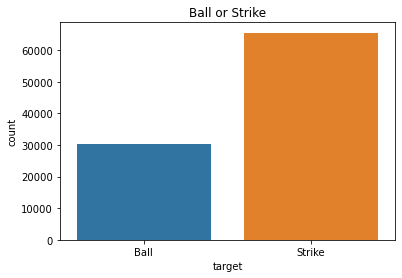

In [212]:
base = sns.countplot(data = df, x = 'target')
base.set(title = 'Ball or Strike')

base.set_xticklabels(['Ball', 'Strike']);

In [213]:
df['target'].value_counts(normalize = True)

1    0.683512
0    0.316488
Name: target, dtype: float64

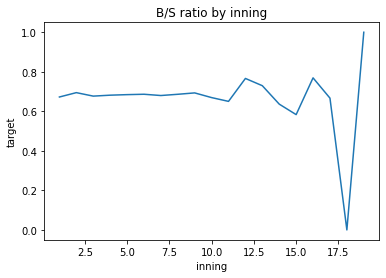

In [214]:
df_inning = df.groupby('inning')['target'].mean().reset_index()
sns.lineplot(data = df_inning, x = 'inning', y = 'target').set_title('B/S ratio by inning');

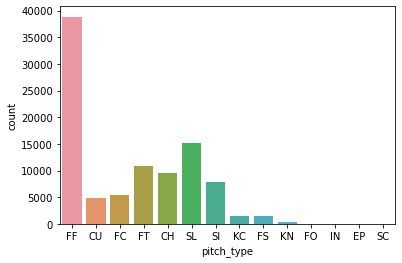

In [215]:
sns.countplot(df['pitch_type']);

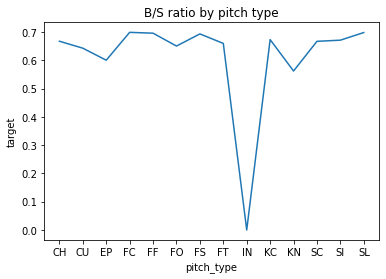

In [216]:
df_type = df.groupby('pitch_type')['target'].mean().reset_index()
sns.lineplot(data = df_type, x = 'pitch_type', y = 'target').set_title('B/S ratio by pitch type');

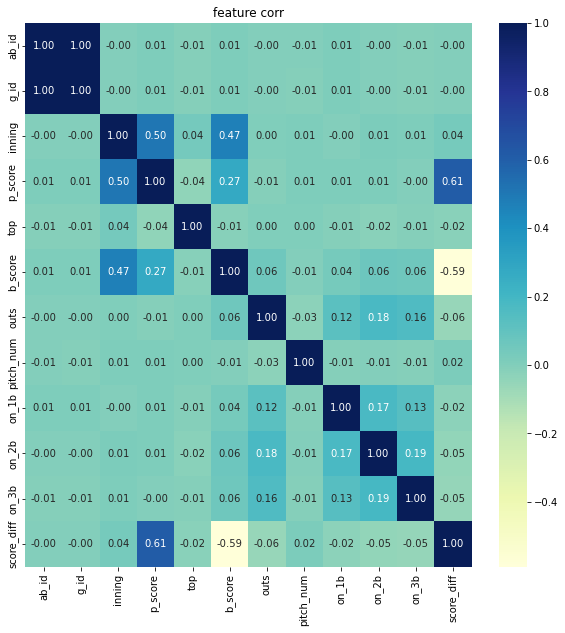

In [217]:
df_corr = df.drop('target', axis = 1)
plt.figure(figsize = (10, 10))
sns.heatmap(df_corr.corr(), annot = True, fmt = '1.2f', cmap = 'YlGnBu').set_title('feature corr');

In [218]:
df.groupby('p_score')['target'].mean()

p_score
0     0.681009
1     0.679345
2     0.676460
3     0.685706
4     0.680566
5     0.691900
6     0.699637
7     0.700377
8     0.701723
9     0.693052
10    0.717617
11    0.712644
12    0.708075
13    0.701087
14    0.736842
15    0.602941
16    0.666667
17    0.736842
18    0.333333
19    0.615385
20    0.000000
21    0.666667
22    0.500000
Name: target, dtype: float64

In [219]:
df.groupby('b_score')['target'].mean()

b_score
0     0.683924
1     0.680526
2     0.693683
3     0.692241
4     0.685512
5     0.680205
6     0.678189
7     0.648849
8     0.663965
9     0.656400
10    0.670699
11    0.700495
12    0.656357
13    0.662577
14    0.712871
15    0.586957
16    0.512195
17    0.774194
18    0.800000
19    0.666667
21    0.000000
Name: target, dtype: float64

In [220]:
df.groupby('score_diff')['target'].mean()

score_diff
-19    0.600000
-18    1.000000
-17    0.000000
-16    0.500000
-15    0.571429
-14    0.687500
-13    0.730769
-12    0.635294
-11    0.714286
-10    0.620000
-9     0.665929
-8     0.637931
-7     0.664474
-6     0.695122
-5     0.659967
-4     0.656058
-3     0.674692
-2     0.688860
-1     0.681453
 0     0.681524
 1     0.686212
 2     0.688601
 3     0.697086
 4     0.689456
 5     0.685193
 6     0.718891
 7     0.698351
 8     0.700000
 9     0.714607
 10    0.734513
 11    0.705426
 12    0.689655
 13    0.727273
 14    0.605263
 15    0.727273
 16    0.600000
 17    0.500000
 18    1.000000
Name: target, dtype: float64

In [221]:
df.dtypes

ab_id            int64
g_id             int64
inning           int64
p_score          int64
p_throws        object
stand           object
top              int32
pitch_type      object
b_score          int32
outs             int32
pitch_num        int32
on_1b            int32
on_2b            int32
on_3b            int32
batter_name     object
pitcher_name    object
score_diff       int64
target           int64
dtype: object

## 모델

In [222]:
target = 'target'
features = df.drop(columns = [target]).columns

In [223]:
train, val = train_test_split(df, test_size = 0.2, random_state = 10)

train.shape, val.shape

((76729, 18), (19183, 18))

In [224]:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = df2[features]
y_test = df2[target]

X_train.shape, X_val.shape, X_test.shape

((76729, 17), (19183, 17), (411, 17))

In [246]:
pipe = Pipeline([
                ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
                ('rf', RandomForestClassifier(random_state=10))
                ])

pipe.named_steps

{'preprocessing': Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                 ('simpleimputer', SimpleImputer())]),
 'rf': RandomForestClassifier(random_state=10)}

In [247]:
pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.6363968096752333


In [248]:
y_pred_val = pipe.predict(X_val)

print('검증세트 accuracy :', accuracy_score(y_val , y_pred_val))
print('검증세트 precision :', precision_score(y_val , y_pred_val))
print('검증세트 recall :', recall_score(y_val , y_pred_val))

검증세트 accuracy : 0.6363968096752333
검증세트 precision : 0.6717834217136478
검증세트 recall : 0.9166031987814166


In [249]:
pipe = Pipeline([
                ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
                ('xgb', XGBClassifier(n_estimators=100, random_state=10, n_jobs=-1))
                ])

pipe.named_steps

{'preprocessing': Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                 ('simpleimputer', SimpleImputer())]),
 'xgb': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None,
               enable_categorical=False, gamma=None, gpu_id=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=-1, num_parallel_tree=None,
               predictor=None, random_state=10, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               validate_parameters=None, verbosity=None)}

In [250]:
pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

[16:36:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
검증 정확도:  0.6761716102799353


In [251]:
y_pred_val = pipe.predict(X_val)

print('검증세트 accuracy :', accuracy_score(y_val , y_pred_val))
print('검증세트 precision :', precision_score(y_val , y_pred_val))
print('검증세트 recall :', recall_score(y_val , y_pred_val))

검증세트 accuracy : 0.6761716102799353
검증세트 precision : 0.6850722311396469
검증세트 recall : 0.9751713632901752


In [252]:
y_pred_proba = pipe.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.970682
1,0.000000,0.000076,0.970682
2,0.000000,0.000228,0.960513
3,0.000165,0.000228,0.957060
4,0.000165,0.000381,0.952445
...,...,...,...
8427,0.999670,0.999695,0.202304
8428,0.999835,0.999695,0.193467
8429,0.999835,0.999848,0.173009
8430,1.000000,0.999848,0.168451


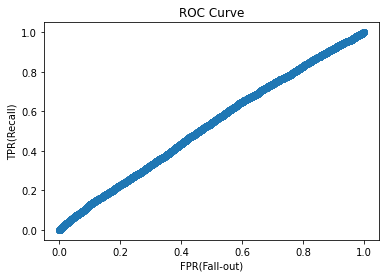

AUC Score : 0.5281557337703296


In [253]:
# ROC Curve
plt.scatter(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');
plt.show()

# AUC Score
auc_score = roc_auc_score(y_val, y_pred_proba)
print('AUC Score :', auc_score)

In [254]:
# 최적의 threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_optimal = y_pred_proba >= optimal_threshold
y_pred_optimal = y_pred_optimal.astype(int)

print('검증세트 accuracy :', accuracy_score(y_val , y_pred_optimal))
print('검증세트 precision :', precision_score(y_val , y_pred_optimal))
print('검증세트 recall :', recall_score(y_val , y_pred_optimal))

검증세트 accuracy : 0.5674294948652453
검증세트 precision : 0.7012997833694384
검증세트 recall : 0.641051028179741


In [255]:
# 튜닝할 하이퍼 파라미터의 범위 지정
dists = {
    'preprocessing__simpleimputer__strategy': ['mean', 'median'],
    'xgb__learning_rate': np.array([0.01,0.001]),
    'xgb__n_estimators': np.array([100,200,300,400,500]),
    'xgb__max_depth':  np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
    }

clf = RandomizedSearchCV(
    pipe,
    param_distributions=dists,
    n_iter=10,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[16:39:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('ordinalencoder',
                                                               OrdinalEncoder(cols=['p_throws',
                                                                                    'stand',
                                                                                    'pitch_type',
                                                                                    'batter_name',
                                                                                    'pitcher_name'],
                                                                              mapping=[{'col': 'p_throws',
                                                                                        'data_type': dtype('O'),
                                                                                        'mapping': L      1
R      2
NaN   -

In [256]:
pipe = clf.best_estimator_

y_pred_val = pipe.predict(X_val)

print('검증세트 accuracy :', accuracy_score(y_val , y_pred_val))
print('검증세트 precision :', precision_score(y_val , y_pred_val))
print('검증세트 recall :', recall_score(y_val , y_pred_val))

검증세트 accuracy : 0.6844601991346505
검증세트 precision : 0.6844601991346505
검증세트 recall : 1.0


In [257]:
y_pred_proba = pipe.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.717672
1,0.000000,0.000076,0.717672
2,0.000000,0.000228,0.717356
3,0.000330,0.000228,0.717196
4,0.000330,0.000381,0.716081
...,...,...,...
6004,0.999670,0.999467,0.566657
6005,0.999835,0.999467,0.564737
6006,0.999835,0.999848,0.547729
6007,1.000000,0.999848,0.546698


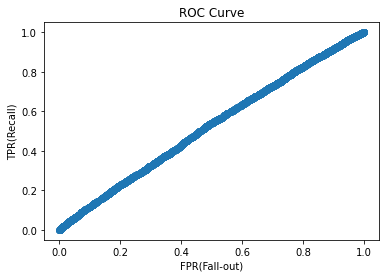

AUC Score : 0.5243193124355072


In [258]:
# ROC Curve
plt.scatter(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');
plt.show()

# AUC Score
auc_score = roc_auc_score(y_val, y_pred_proba)
print('AUC Score :', auc_score)

In [259]:
y_pred_test = pipe.predict(X_test)

print('테스트세트 accuracy :', accuracy_score(y_test , y_pred_test))
print('테스트세트 precision :', precision_score(y_test , y_pred_test))
print('테스트세트 recall :', recall_score(y_test , y_pred_test))

테스트세트 accuracy : 0.44768856447688565
테스트세트 precision : 0.44768856447688565
테스트세트 recall : 1.0


In [260]:
model = pipe.named_steps['xgb']

permuter = PermutationImportance(
    model, # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)
permuter.fit(X_val_transformed, y_val)

feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names
)

Weight,Feature
0.0000 ± 0.0000,pitch_type
0 ± 0.0000,score_diff
0 ± 0.0000,g_id
0 ± 0.0000,inning
0 ± 0.0000,p_score
0 ± 0.0000,p_throws
0 ± 0.0000,stand
0 ± 0.0000,top
0 ± 0.0000,b_score
0 ± 0.0000,pitcher_name


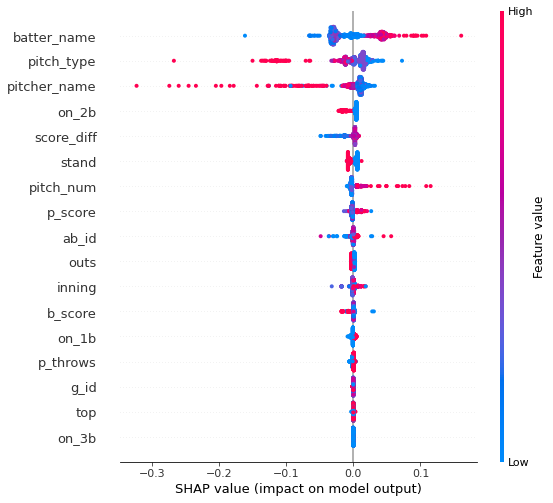

In [261]:
encoder = OrdinalEncoder()
X_train_encoder = encoder.fit_transform(X_train)
X_val_encoder = encoder.fit_transform(X_val)

explainer = shap.TreeExplainer(pipe.named_steps['xgb'])
shap_values = explainer.shap_values(X_val_encoder.iloc[:1000])
shap.summary_plot(shap_values, X_val_encoder.iloc[:1000])

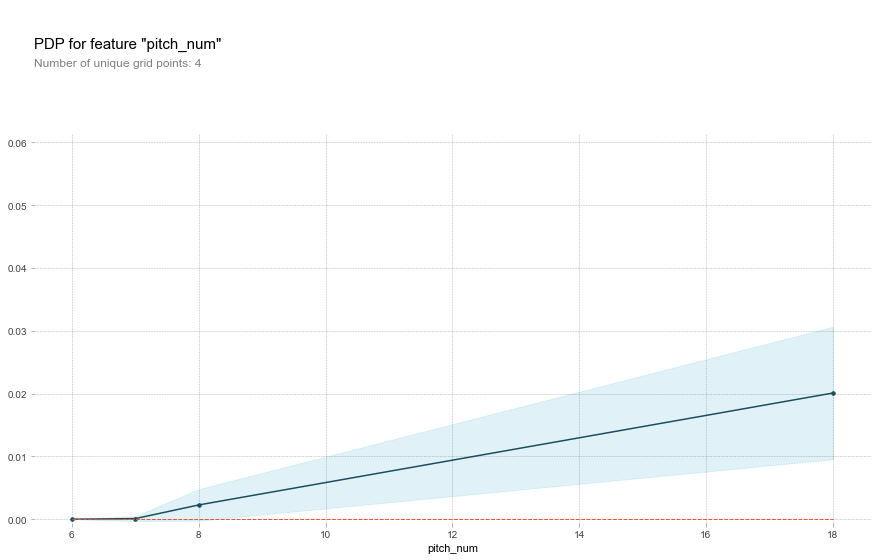

In [262]:
feature = 'pitch_num'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile'
)
pdp_plot(isolated, feature_name=feature);

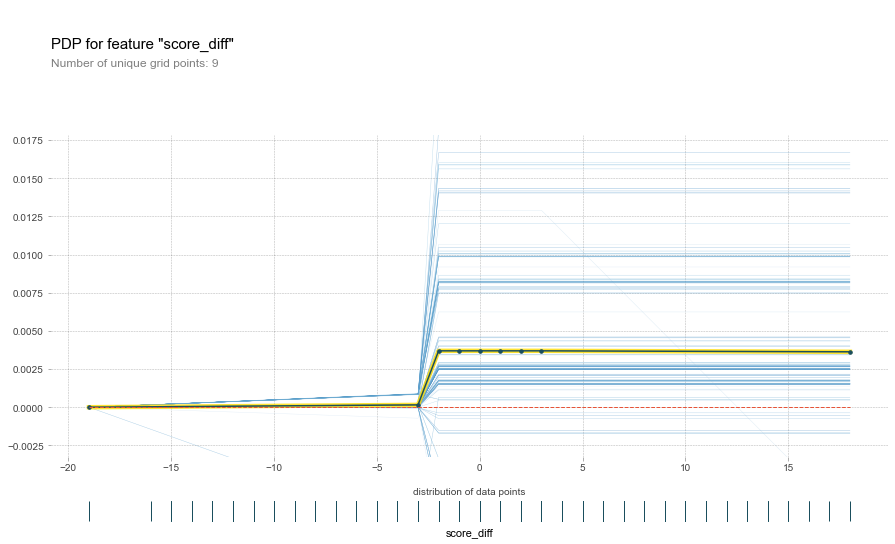

In [263]:
feature = 'score_diff'

isolated = pdp_isolate(
    model=pipe, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated
         , feature_name=feature
         , plot_lines=True
         , frac_to_plot=0.01
         , plot_pts_dist=True);

In [266]:
y = y_test.iloc[[77]]
row = X_test.iloc[[77]]
row

,ab_id,g_id,inning,p_score,p_throws,stand,top,pitch_type,b_score,outs,pitch_num,on_1b,on_2b,on_3b,batter_name,pitcher_name,score_diff
80,2019029585,201900389,5,1,R,L,1,SL,1,2,6,0,0,0,Mike Freeman,Brad Peacock,0


In [267]:
encoder = OrdinalEncoder()
X_train_encoder = encoder.fit_transform(X_train)
X_test_encoder = encoder.fit_transform(row)


explainer = shap.TreeExplainer(pipe.named_steps['xgb'])
shap_values = explainer.shap_values(X_test_encoder)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=X_test_encoder
)